In [1]:
from warnings import filterwarnings

filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from crypto_momentum_portfolios.utility.data_loader import CryptoDataLoaderQIL
from crypto_momentum_portfolios.utility.types import (
    DataFrequency,
    Fields,
    RebalanceFrequency,
    Side,
    RankingMode,
    AllocationMethod,
    RankingMethod,
    AllocationMode,
    Benchmark,
)
from crypto_momentum_portfolios.portfolio_management.benchmarks import (
    BenchmarkDataFrameBuilder,
)
from crypto_momentum_portfolios.portfolio_management.backtester import (
    PortfolioBacktester,
)

dl = CryptoDataLoaderQIL()  # CryptoDataLoader()
dl.assets

Loading BokehJS ...

Fetching symbols...: 100%|██████████| 21/21 [00:00<00:00, 35.07it/s]


['BTC-USDT',
 'MATIC-USDT',
 'LTC-USDT',
 'ADA-USDT',
 'XLM-USDT',
 'ATOM-USDT',
 'XRP-USDT',
 'XTZ-USDT',
 'ETC-USDT',
 'DOGE-USDT',
 'ETH-USDT',
 'SOL-USDT',
 'VET-USDT',
 'LINK-USDT',
 'DASH-USDT',
 'BCH-USDT',
 'KDA-USDT',
 'BNB-USDT',
 'EOS-USDT',
 'TRX-USDT',
 'AVAX-USDT']

In [2]:
MOMENTUM_LOOKBACK = 30
universe = (
    dl.get_crypto(
        "all",
        data_frequency=DataFrequency.DAILY,
        fields=[
            Fields.PRICE,
            Fields.MARKET_CAP,
            Fields.MOMENTUM,
            Fields.EMA_MOMENTUM,
            Fields.TS_MOMENTUM,
            Fields.VOLATILITY_NEUTRALIZED_MOMENTUM,
            Fields.RETURNS,
            Fields.VOLATILITY,
            Fields.VOLUME,
        ],
        flatten_fields_with_crypto=False,
        momentum_lookback=MOMENTUM_LOOKBACK,
    )
    .dropna()
    .loc[:]  # "2021-10-28"
)
universe.head()

price                                                    \
           BTC-USDT MATIC-USDT LTC-USDT  ADA-USDT  XLM-USDT ATOM-USDT   
Date                                                                    
2021-09-02  49248.9     1.4453  183.366  2.960618  0.359000   24.1422   
2021-09-03  50011.0     1.4559  213.000  2.965665  0.368773   24.1158   
2021-09-04  49902.6     1.7374  211.956  2.828828  0.369760   24.3884   
2021-09-05  51768.0     1.6803  232.371  2.911501  0.397779   25.7148   
2021-09-06  52667.2     1.6435  219.419  2.830175  0.423930   25.1007   

                                                 ...        volume  \
           XRP-USDT XTZ-USDT ETC-USDT DOGE-USDT  ...      SOL-USDT   
Date                                             ...                 
2021-09-02  1.25337  5.29412  67.6071   0.29450  ...  3.756954e+07   
2021-09-03  1.29075  5.31364  69.9936   0.29612  ...  5.825224e+07   
2021-09-04  1.25500  5.40328  68.7689   0.29928  ...  3.278846e+07   
2021-09-05  1.30769  5.56640  73.5208   0.31436  ...  2.985273e+07   
2021-09-06  1.38957  5.59636  73.4993   0.30905  ...  4.597036e+07   

                                                                    \
                VET-USDT     LINK-USDT     DASH-USDT      BCH-USDT   
Date                                                                 
2021-09-02  4.366786e+07  1.839220e+07  1.117699e+06  3.282440e+06   
2021-09-03  3.520757e+07  1.698059e+07  1.633416e+06  6.891993e+06   
2021-09-04  2.508443e+07  1.015540e+07  1.753706e+06  7.789447e+06   
2021-09-05  2.032786e+07  1.718075e+07  1.719181e+06  5.961379e+06   
2021-09-06  2.940524e+07  3.100928e+07  1.516422e+06  8.929510e+06   

                                                                    \
                KDA-USDT      BNB-USDT      EOS-USDT      TRX-USDT   
Date                                                                 
2021-09-02  7.926466e+05  2.798852e+07  8.027218e+06  1.228910e+07   
2021-09-03  1.065176e+06  2.585108e+07  1.095528e+07  1.120307e+07   
2021-09-04  6.648969e+05  3.431727e+07  1.176539e+07  7.332294e+06   
2021-09-05  8.942949e+05  2.350295e+07  1.376169e+07  7.281659e+06   
2021-09-06  2.234403e+06  2.661392e+07  1.304758e+07  6.844546e+06   

                          
               AVAX-USDT  
Date                      
2021-09-02  1.260635e+07  
2021-09-03  2.368620e+07  
2021-09-04  1.644097e+07  
2021-09-05  1.239841e+07  
2021-09-06  1.999695e+07  

[5 rows x 189 columns]

Weight drift :

$$w_i^k=\frac{w_{i-1}^k\times (1+r_i^k)}{\sum_{j=1}^n w_{i-1}^j\times(1+r_i^j)}$$

For asset $k$ at time $i$ given $n$ asset in the portfolio.


# Building a benchmark


## Capitalization weighted index


In [3]:
benchmarks = (
    BenchmarkDataFrameBuilder(universe)
    .build_equally_weighted_benchmark(
        rebalance_frequency=RebalanceFrequency.MONTHLY, side=Side.LONG, verbose=False
    )
    .build_capitalization_weighted_benchmark(
        capitalization_field=Fields.MARKET_CAP,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        verbose=False,
    )
    .build_bitcoin_benchmark()
    .collect_benchmark_returns()
)
benchmarks

,equal_weighted_benchmark,capi_weighted_benchmark,bitcoin_benchmark
Date,,,
2021-09-02,-0.004464,-0.006258,0.008882
2021-09-03,0.032272,0.026301,0.015474
2021-09-04,0.002686,-0.012745,-0.002168
2021-09-05,0.052077,0.034408,0.037381
2021-09-06,0.013265,0.010569,0.017370
...,...,...,...
2023-12-31,-0.027769,-0.021316,0.003127
2024-01-01,0.043029,0.045546,0.044894
2024-01-02,-0.020277,-0.004449,0.017326


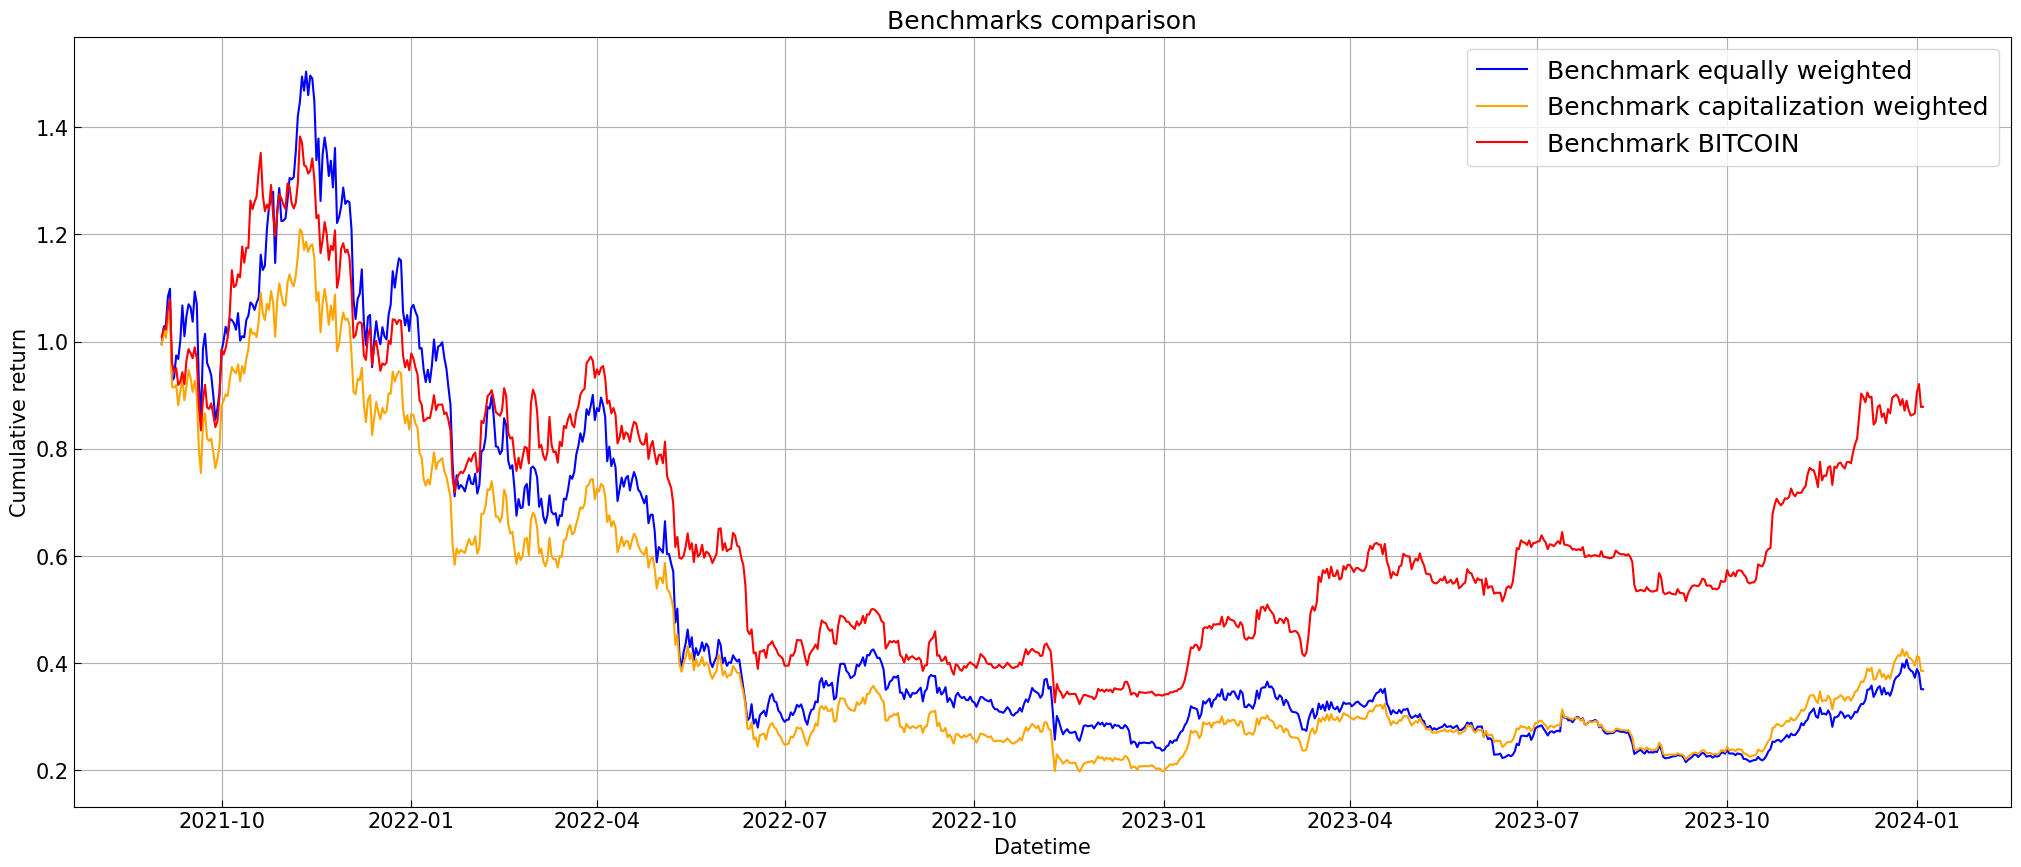

In [4]:

fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
# plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

f, ax = plt.subplots(1, 1, figsize=(25, 10))
ax.set_title("Benchmarks comparison", fontsize=18)
ax.grid()
ax.plot(
    (benchmarks["equal_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark equally weighted",
    color="blue",
)
ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark capitalization weighted",
    color="orange",
)
ax.plot(
    (benchmarks["bitcoin_benchmark"] + 1).cumprod(),
    label="Benchmark BITCOIN",
    color="red",
)


ax.set_xlabel("Datetime",)
ax.set_ylabel("Cumulative return",)
ax.legend(loc="upper right",)
# ax.set_yscale("log")

# Backtesting strategies


## Backtesting with a benchmark and a strategy


In [5]:
ptf_backtester = PortfolioBacktester(universe=universe,)

returns_capi, _ = ptf_backtester.run_strategy(
    ranking_method=RankingMethod.EMA_MOMENTUM,
    ranking_mode=RankingMode.DESCENDING,
    select_top_k_assets=5,
    allocation_method=AllocationMethod.MEAN_VARIANCE,
    allocation_mode=AllocationMode.CLASSIC,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    benchmark=Benchmark.CAPITALIZATION_WEIGHTED,
    verbose=False,
    print_stats=True,
    plot_curve=True,
    perform_t_stats=True
)


-----------------Expected return------------------
Benchmark: -19.58% vs Strategy: 76.03%

t-stat: 20.83, p-value: 0.00
Statistically different from the bench

-----------------------CAGR-----------------------
Benchmark: -33.28% vs Strategy: 33.11%

t-stat: 11.55, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 64.69% vs Strategy: 96.33%

t-stat: 91.29, p-value: 0.00
Statistically different from the bench

---------------------Skewness---------------------
Benchmark: -0.33 vs Strategy: 0.64

t-stat: 37.39, p-value: 0.00
Statistically different from the bench

---------------------Kurtosis---------------------
Benchmark: 2.96 vs Strategy: 5.10

t-stat: 15.04, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.75% vs Strategy: -7.24%

t-stat: -34.97, p-value: 0.00
Statistically different from the bench

-----------------------CVaR----------------------

Loading BokehJS ...

Loading BokehJS ...

## Several strategies


In [ ]:
ptf_backtester = PortfolioBacktester(universe=universe)

returns_capi, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.CAPITALIZATION_WEIGHTED,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_capi.name = "capitalization_weighted"

returns_rp, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.RISK_PARITY,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_rp.name = "risk_parity"
returns_mv, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.MEAN_VARIANCE,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_mv.name = "mean_variance"
returns, weights_df = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.EQUAL_WEIGHTED,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns.name = "equal_weighted"

In [ ]:
returns_df = pd.concat([returns, returns_capi, returns_rp, returns_mv], axis=1)
returns_df

### Plot all strategies


In [ ]:
ax = (returns_df + 1).cumprod().plot(figsize=(25, 10), grid=True)

ax.set_title(
    "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
)

ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="capi_weighted_benchmark",
    color="black",
)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper left")
# ax.set_yscale("log")

### Plot one strategy


In [ ]:
f, ax = plt.subplots(1, 1, figsize=(25, 10))

ax.set_title(
    "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
)
ax.plot(
    (returns_df["mean_variance"] + 1).cumprod(),
    label="Stretegy",
    color="blue",
)

ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="capi_weighted_benchmark",
    color="orange",
)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper left")
# ax.set_yscale("log")

ax.grid()

## Weights analysis


In [ ]:
weights_df